In [420]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier, DummyRegressor
import numpy as np
# Preprocessing and pipeline
from sklearn.impute import SimpleImputer
import mglearn
# train test split and cross validation
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    StandardScaler,
)
import altair as alt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

In [421]:
grade_df = pd.read_csv('data/additional/gradebook.csv')
discussion_df = pd.read_csv('data/additional/discussions.csv')
discussion_topic_df = pd.read_csv('data/additional/discussion_topics.csv')

discussion_df['id'] = discussion_df['discussion_topic_id']
discussion_combined_df = discussion_df.merge(discussion_topic_df)

grade_df['actor_id'] = grade_df['Student']
df = grade_df.merge(discussion_df)

enrol_df = pd.read_csv('data/additional/enrollments.csv')
enrol_df['Student'] = enrol_df['user_id']
df = df.merge(enrol_df)

num_cols = ['Assignment 1 (c81f04547a95da2a7b88054ef491b7c4)',
       'Assignment 2 (a4dc11e7e79361fc5886a9078aac66b8)',
       'Assignment 3 (option A) (811d93ea379b5cdd5a19f1b5dbab88cd)',
       'Assignment 3 (option B) (df8d1f1ff3f48fdc24a278b40c5f45cc)',
       'Assignment 3 (option C) (bb971b36c1578cede00150acda89aa99)',
       'Assignment 3 (option D) (f1ad954cd2cddda6e17f6fc225d1aa3e)',
       'Participation grade: Formative (not included in final grade) (5965e0b0c712861d0efdd9be54572114)',
       'Assignment 1 Current Score', 'Assignment 2 Current Score',
       'Assignment 3 Current Score',
       'Participation & engagement Current Score', 'Current Score',]

for col in num_cols:
    df[col] = df[col].apply(float)


In [422]:
df_mean = df.groupby('Student').aggregate('mean')
df_sum = df.groupby('Student').aggregate('sum')
df_count = df.groupby('Student').aggregate('count')

canvas_df = pd.concat([df_mean[['Participation & engagement Current Score','Current Score',
                                'count_of_likes','total_activity_time']], 
                       df_sum[['discussion_topic_message_length','post_message_length']],
                      df_count[['last_activity_at']]],axis =1)

canvas_df['answer_count'] =  canvas_df['last_activity_at']
canvas_df = canvas_df.drop(['last_activity_at'],axis = 1)

In [423]:
canvas_df.head()

Participation & engagement Current Score  Current Score  \
Student                                                               
LEARNER_1                                       90.0           80.9   
LEARNER_10                                      85.0           78.4   
LEARNER_11                                      90.0           84.3   
LEARNER_12                                      80.0           81.2   
LEARNER_13                                      80.0           85.5   

            count_of_likes  total_activity_time  \
Student                                           
LEARNER_1         0.214286             985351.0   
LEARNER_10        0.298246             421763.0   
LEARNER_11        0.156250             285214.0   
LEARNER_12        0.200000             176035.0   
LEARNER_13        0.219512             774430.0   

            discussion_topic_message_length  post_message_length  answer_count  
Student                                                                         
LEARNER_1                             12207                33617            14  
LEARNER_10                            48509                60378            57  
LEARNER_11                            31952                40861            32  
LEARNER_12                            19072                22838            20  
LEARNER_13                            36887                44122            41

In [424]:
train_df, test_df = train_test_split(canvas_df, test_size=0.2, random_state=1)

train_df.head()

Participation & engagement Current Score  Current Score  \
Student                                                               
LEARNER_35                                      80.0           79.1   
LEARNER_34                                      90.0           81.3   
LEARNER_6                                      100.0           92.2   
LEARNER_26                                     100.0           87.5   
LEARNER_31                                      70.0           77.9   

            count_of_likes  total_activity_time  \
Student                                           
LEARNER_35        0.318182             209140.0   
LEARNER_34        0.071429             604326.0   
LEARNER_6         0.144578             426200.0   
LEARNER_26        0.181818             254157.0   
LEARNER_31        0.269231            1011355.0   

            discussion_topic_message_length  post_message_length  answer_count  
Student                                                                         
LEARNER_35                            21400                39814            22  
LEARNER_34                            28522                41271            28  
LEARNER_6                            137378               128557           166  
LEARNER_26                            32698                42242            33  
LEARNER_31                            27721                31634            26

In [425]:
X_train = train_df.drop(['Current Score'], axis=1)
X_test = test_df.drop(['Current Score'], axis=1)
y_train = train_df['Current Score']
y_test = test_df['Current Score']

In [426]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

-0.2705326923623772

In [427]:
pd.DataFrame(dummy.predict(X_test), y_test, columns = ['prediction'])

prediction
Current Score            
89.2            80.565385
85.7            80.565385
81.2            80.565385
82.3            80.565385
87.3            80.565385
70.9            80.565385
89.0            80.565385

In [428]:
mean_squared_error(dummy.predict(X_test),y_test, squared = False)

6.70021242771455

In [429]:
mean_squared_error(dummy.predict(X_train),y_train, squared = False)

6.36891140968209

In [430]:
svr = SVR()
scaler = StandardScaler()
pipe = make_pipeline(scaler, svr)
pipe.fit(X_train, y_train)
mean_absolute_percentage_error(pipe.predict(X_test),y_test)

0.06241100284836674

In [431]:
mean_squared_error(pipe.predict(X_test),y_test, squared = False)

5.636609572664642

In [432]:
pd.DataFrame(np.array([pipe.predict(X_test),
             y_test]).T, 
             columns = ['prediction', 'target'])

prediction  target
0   81.843087    89.2
1   80.363086    85.7
2   81.231397    81.2
3   79.547510    82.3
4   81.108387    87.3
5   78.496339    70.9
6   82.985423    89.0

In [433]:
pipe_svm = make_pipeline(StandardScaler(), SVR())

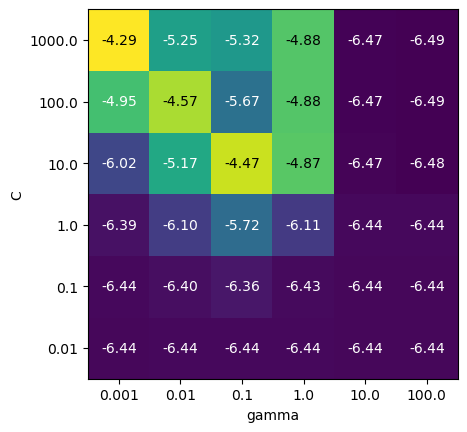

In [434]:
def display_heatmap(param_grid, pipe, X_train, y_train):
    grid_search = GridSearchCV(
        pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True, scoring='neg_root_mean_squared_error'
    )
    grid_search.fit(X_train, y_train)
    results = pd.DataFrame(grid_search.cv_results_)
    scores = np.array(results.mean_test_score).reshape(6, 6)

    # plot the mean cross-validation scores
    mglearn.tools.heatmap(
        scores,
        xlabel="gamma",
        xticklabels=param_grid["svr__gamma"],
        ylabel="C",
        yticklabels=param_grid["svr__C"],
        cmap="viridis",
    );
param_grid1 = {
    "svr__gamma": 10.0**np.arange(-3, 3, 1), 
    "svr__C": 10.0**np.arange(-2, 4, 1)
}
display_heatmap(param_grid1, pipe_svm, X_train, y_train)

In [435]:
grid_search = GridSearchCV(
        pipe_svm, param_grid1, cv=5, n_jobs=-1, return_train_score=True
    )

grid_search.fit(X_train, y_train)
res = pd.DataFrame(grid_search.predict(X_test), y_test, columns = ['prediction']).reset_index()
res

Current Score  prediction
0           89.2   88.987391
1           85.7   78.033786
2           81.2   82.084125
3           82.3   76.661049
4           87.3   84.276034
5           70.9   74.774420
6           89.0   85.983677

In [436]:
grid_search.best_params_

{'svr__C': 1000.0, 'svr__gamma': 0.001}

In [437]:
grid_search.score(X_test, y_test)

0.4960353125167132

In [ ]:
mean_squared_error(grid_search.predict(X_train),y_train, squared = False)

In [438]:
mean_squared_error(grid_search.predict(X_test),y_test, squared = False)

4.219837266716895

In [439]:
x = 10.0**np.arange(-5,3, 0.01)
res = []
for i in (x):
    ridge = Ridge(alpha=i)

    pipe = make_pipeline(StandardScaler(), ridge)
    pipe.fit(X_train, y_train)
    res.append(mean_squared_error(pipe.predict(X_test),y_test, squared = False))

Text(0, 0.5, 'Score')

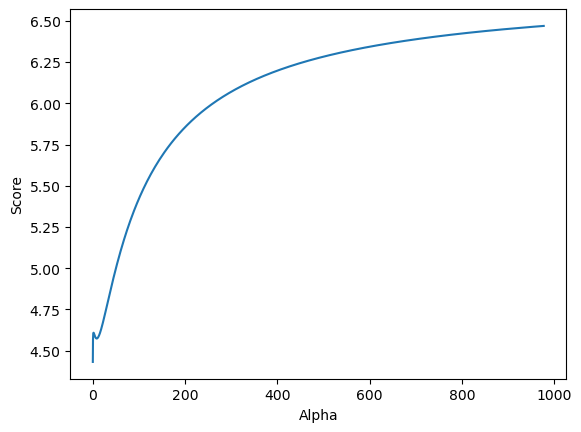

In [440]:
plt.plot(x, res)
plt.xlabel('Alpha')
plt.ylabel('Score')

In [441]:
from sklearn.linear_model import RidgeCV
ridge = RidgeCV(x)

pipe = make_pipeline(StandardScaler(), ridge)
pipe.fit(X_train, y_train)

pd.DataFrame(np.array([pipe.predict(X_test),
             y_test]).T, 
             columns = ['prediction', 'target'])


prediction  target
0   86.723329    89.2
1   78.518049    85.7
2   81.176540    81.2
3   77.759871    82.3
4   83.294532    87.3
5   75.907095    70.9
6   83.797426    89.0

In [442]:
mean_squared_error(pipe.predict(X_train),y_train, squared = False)

3.5853104151552087

In [443]:
mean_squared_error(pipe.predict(X_test),y_test, squared = False)

4.574919102963637

In [444]:
coeffs = pipe['ridgecv'].coef_
feature_names = X_train.columns
viz_df = pd.DataFrame(coeffs,feature_names).reset_index()
viz_df.columns = ['coefficient', 'importance']
viz_df

coefficient  importance
0  Participation & engagement Current Score    2.811733
1                            count_of_likes    1.313445
2                       total_activity_time   -0.971734
3           discussion_topic_message_length    0.262782
4                       post_message_length    0.823837
5                              answer_count    0.526499

In [445]:
chart = alt.Chart(viz_df).transform_calculate(
    negative='datum.y < 0'
).mark_bar().encode(
    x='importance',
    y=alt.Y('coefficient', impute={'value': 0}),
)
import vl_convert as vlc
def save_chart(chart, filename, scale_factor=1):
    '''
    Save an Altair chart using vl-convert
    
    Parameters
    ----------
    chart : altair.Chart
        Altair chart to save
    filename : str
        The path to save the chart to
    scale_factor: int or float
        The factor to scale the image resolution by.
        E.g. A value of `2` means two times the default resolution.
    '''
    with alt.data_transformers.enable("default"), alt.data_transformers.disable_max_rows():
        if filename.split('.')[-1] == 'svg':
            with open(filename, "w") as f:
                f.write(vlc.vegalite_to_svg(chart.to_dict()))
        elif filename.split('.')[-1] == 'png':
            with open(filename, "wb") as f:
                f.write(vlc.vegalite_to_png(chart.to_dict(), scale=scale_factor))
        else:
            raise ValueError("Only svg and png formats are supported")
save_chart(chart, 'chart.png',2)
chart

alt.Chart(...)

In [446]:
splom = train_df[['Participation & engagement Current Score', 'Current Score','answer_count']]

In [447]:
alt.Chart(splom).mark_point(opacity=0.6, size=20).encode(
     alt.X(alt.repeat('row'), type='quantitative', scale=alt.Scale(zero=False)),
     alt.Y(alt.repeat('column'), type='quantitative', scale=alt.Scale(zero=False))
).properties(
    width=200,
    height=200
).repeat(
    column=['Participation & engagement Current Score','Current Score', 'answer_count'],
    row=['Participation & engagement Current Score', 'Current Score','answer_count']
)

alt.RepeatChart(...)

In [448]:
from sklearn.linear_model import LassoCV

In [449]:
lasso = LassoCV()
scaler = StandardScaler()
pipe = make_pipeline(scaler, lasso)
pipe.fit(X_train, y_train)
pipe.score(X_test,y_test)

0.45218810760505845

In [450]:
mean_squared_error(pipe.predict(X_test),y_test, squared = False)

4.399581608161806

In [451]:
coeffs = pipe['lassocv'].coef_
feature_names = X_train.columns
viz_df = pd.DataFrame(coeffs,feature_names).reset_index()
viz_df.columns = ['coefficient', 'importance']
viz_df

coefficient  importance
0  Participation & engagement Current Score    3.976999
1                            count_of_likes    1.019421
2                       total_activity_time   -0.944498
3           discussion_topic_message_length    0.000000
4                       post_message_length    0.297367
5                              answer_count    0.514305

In [452]:
alt.Chart(viz_df).transform_calculate(
    negative='datum.y < 0'
).mark_bar().encode(
    x='importance',
    y=alt.Y('coefficient', impute={'value': 0}),
)

alt.Chart(...)

In [453]:
pd.DataFrame(np.array([pipe.predict(X_test),
             y_test]).T, 
             columns = ['prediction', 'target'])

prediction  target
0   87.270207    89.2
1   78.627224    85.7
2   81.894323    81.2
3   77.619396    82.3
4   83.508352    87.3
5   75.928968    70.9
6   84.562802    89.0

In [454]:
from catboost import CatBoostRegressor
from sklearn.preprocessing import PolynomialFeatures

In [455]:
preprocessor = make_pipeline(PolynomialFeatures(),StandardScaler())

In [456]:
pipe = make_pipeline(preprocessor, CatBoostRegressor(verbose = False,
                                                         learning_rate=0.03, 
                                                         random_state = 1))
pipe.fit(X_train, y_train)
mean_squared_error(pipe.predict(X_test),y_test, squared = False)

3.6788170542254446

In [457]:
param_grid = {
    "catboostregressor__learning_rate": np.arange(0.1,1,0.1),
    "catboostregressor__max_depth": np.arange(4,10,1),
}

grid_search = GridSearchCV(
    pipe, 
    param_grid,
    cv=5,
    n_jobs=-1,
    return_train_score=True,
    scoring ='neg_root_mean_squared_error'
)
grid_search.fit(X_train, y_train)
grid_search.best_score_

-4.4629729219912475

In [458]:
grid_search.best_params_

{'catboostregressor__learning_rate': 0.30000000000000004,
 'catboostregressor__max_depth': 4}

In [459]:
mean_squared_error(grid_search.predict(X_train),y_train, squared = False)

2.116013164915183e-06

In [460]:
mean_squared_error(grid_search.predict(X_test),y_test, squared = False)

2.875134540570218

In [461]:
p = PolynomialFeatures()
p.fit(X_train)


PolynomialFeatures()

In [462]:
import shap
shap.initjs()
pipe = make_pipeline(preprocessor, CatBoostRegressor(verbose=False,
                                                         max_depth=4,
                                                         learning_rate=0.03,
                                                         random_state=1))
pipe.fit(X_train, y_train)

X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test),
    columns=p.get_feature_names_out(),
    index=X_test.index,
)

cat_explainer = shap.TreeExplainer(pipe["catboostregressor"])
test_cat_shap_values = cat_explainer.shap_values(X_test_enc)

In [463]:
sample = 3
print(y_test[sample])
shap.force_plot(
    cat_explainer.expected_value,
    test_cat_shap_values[sample, :],
    X_test_enc.iloc[sample, :]
)

82.3
